<a href="https://colab.research.google.com/github/qpwisu/datascience/blob/master/stock_decisiontree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

현재의 코스피 지수와 비슷한 흐름을 갖는 과거 타이밍을 찾아서 
그 날짜에 모든 종목들을 결정트리로 주식가격이 3프로 이상 증가하는 조건을 찾아보려고 합니다 
오늘 날짜 2021827 
코스닥이 다음 개장날에 꺽인다는 가정하에 20210507, 20210510 , 20210511 일 증감률을 이용해 조건을 찾아보겠습니다 


예측 - 코스닥이 830일에 하락하는 경우 3이상 상승할꺼라 예측
060720 
192080 
361390
067000
192820


In [1]:
pip install pykrx 


     |████████████████████████████████| 81 kB 3.6 MB/s 
     |████████████████████████████████| 60 kB 7.0 MB/s 
     |████████████████████████████████| 251 kB 25.4 MB/s 


In [2]:
pip install sklearn 

In [3]:
pip install pymysql


     |████████████████████████████████| 43 kB 1.0 MB/s 


In [4]:
pip install numpy

In [93]:
from pykrx import stock
import pandas
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import pymysql
import numpy as np
start_day ='20210507'
end_day = '20210511'

# 주식 개장일만 뽑아서 리스트로 만들기 
dt_index = pandas.date_range(start=start_day, end=end_day,freq='B')
dt_list = dt_index.strftime("%Y%m%d").tolist()

# 데이터프레임을 만들어서 모든 주식 종목에 start_day의 등락률을 넣어줌
df_percent= stock.get_market_price_change_by_ticker(dt_list[0],dt_list[0],market="ALL")['등락률']
df_percent=pandas.DataFrame(df_percent)
df_percent.columns=[dt_list[0]]

# 리스트에 들어있는 날짜들에 모든 종목 등락률을 concat해서 데이터프레임에 합침 
for i in range(1,len(dt_index)):
    try:
        df = stock.get_market_price_change_by_ticker(dt_list[i], dt_list[i],market="ALL")['등락률']
        df = pandas.DataFrame(df)
        df.columns = [dt_list[i]]
        df_percent = pandas.concat([df, df_percent], axis=1)
    except:
        continue

# NAN값이 있는 행을 제거 
df_percent=df_percent.dropna(axis=0)

# end_day 열에 float값을 int형으로 변환
df_percent[[end_day]] = df[[end_day]].applymap(np.int64)

print(df_percent)

        20210511  20210510  20210507
060310        -1     -0.50      3.98
095570         2      3.89      0.34
006840         1      5.47      1.86
054620         1      5.54     -0.34
265520         0      1.91      1.05
...          ...       ...       ...
000547       -13      2.07     -2.64
000545        -5      4.69     -3.40
003280         0      0.00      0.00
037440         0      3.77      4.40
238490        -3      0.00      1.15

[2557 rows x 3 columns]


In [94]:
# end_day 행에 등락률이 3프로 이상이면 1 미만이면 0
for i in range(len(df_percent)):
  if df_percent[end_day][i]>=3:
    df_percent[end_day][i]=1
  else:
    df_percent[end_day][i]=0

print(df_percent)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


        20210511  20210510  20210507
060310         0     -0.50      3.98
095570         0      3.89      0.34
006840         0      5.47      1.86
054620         0      5.54     -0.34
265520         0      1.91      1.05
...          ...       ...       ...
000547         0      2.07     -2.64
000545         0      4.69     -3.40
003280         0      0.00      0.00
037440         0      3.77      4.40
238490         0      0.00      1.15

[2557 rows x 3 columns]


In [95]:
# data에는 end_day 행에 등락률을 제외한 dataframe을 numpy로 변환해서 넣고 
# target에서 end_day행에 등락률을 numpy로 변화해서 넣음
data = df_percent[[df_percent.columns[i] for i in range(1,len(df_percent.columns))]].to_numpy()
target = df_percent[[df_percent.columns[0]]].to_numpy()
# 훈련데이터와 테스트데이터를 8:2비율로 나눔
train_input,test_input,train_target,test_target = train_test_split(data,target,test_size=0.2)



In [96]:
# standartscaler로 표준화 전처리해줌 but 결정트리에서는 딱히 필요없음 
from sklearn.preprocessing import StandardScaler
ss= StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)


In [97]:
#로지스틱회귀로 학습 
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_scaled,train_target)
print(lr.score(train_scaled,train_target))
print(lr.score(test_scaled,test_target))

0.908557457212714
0.875


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [98]:
# 결정트리 / 과대적합됨 
from sklearn.tree import DecisionTreeClassifier
dt= DecisionTreeClassifier(random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled,train_target))
print(dt.score(test_scaled,test_target))

0.9965770171149144
0.818359375


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


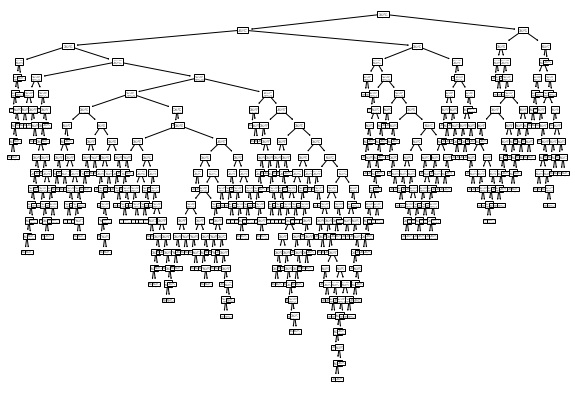

In [99]:
import matplotlib.pyplot as plt 
from sklearn.tree import plot_tree
plt.figure(figsize=(10,7))
plot_tree(dt)
plt.show()

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


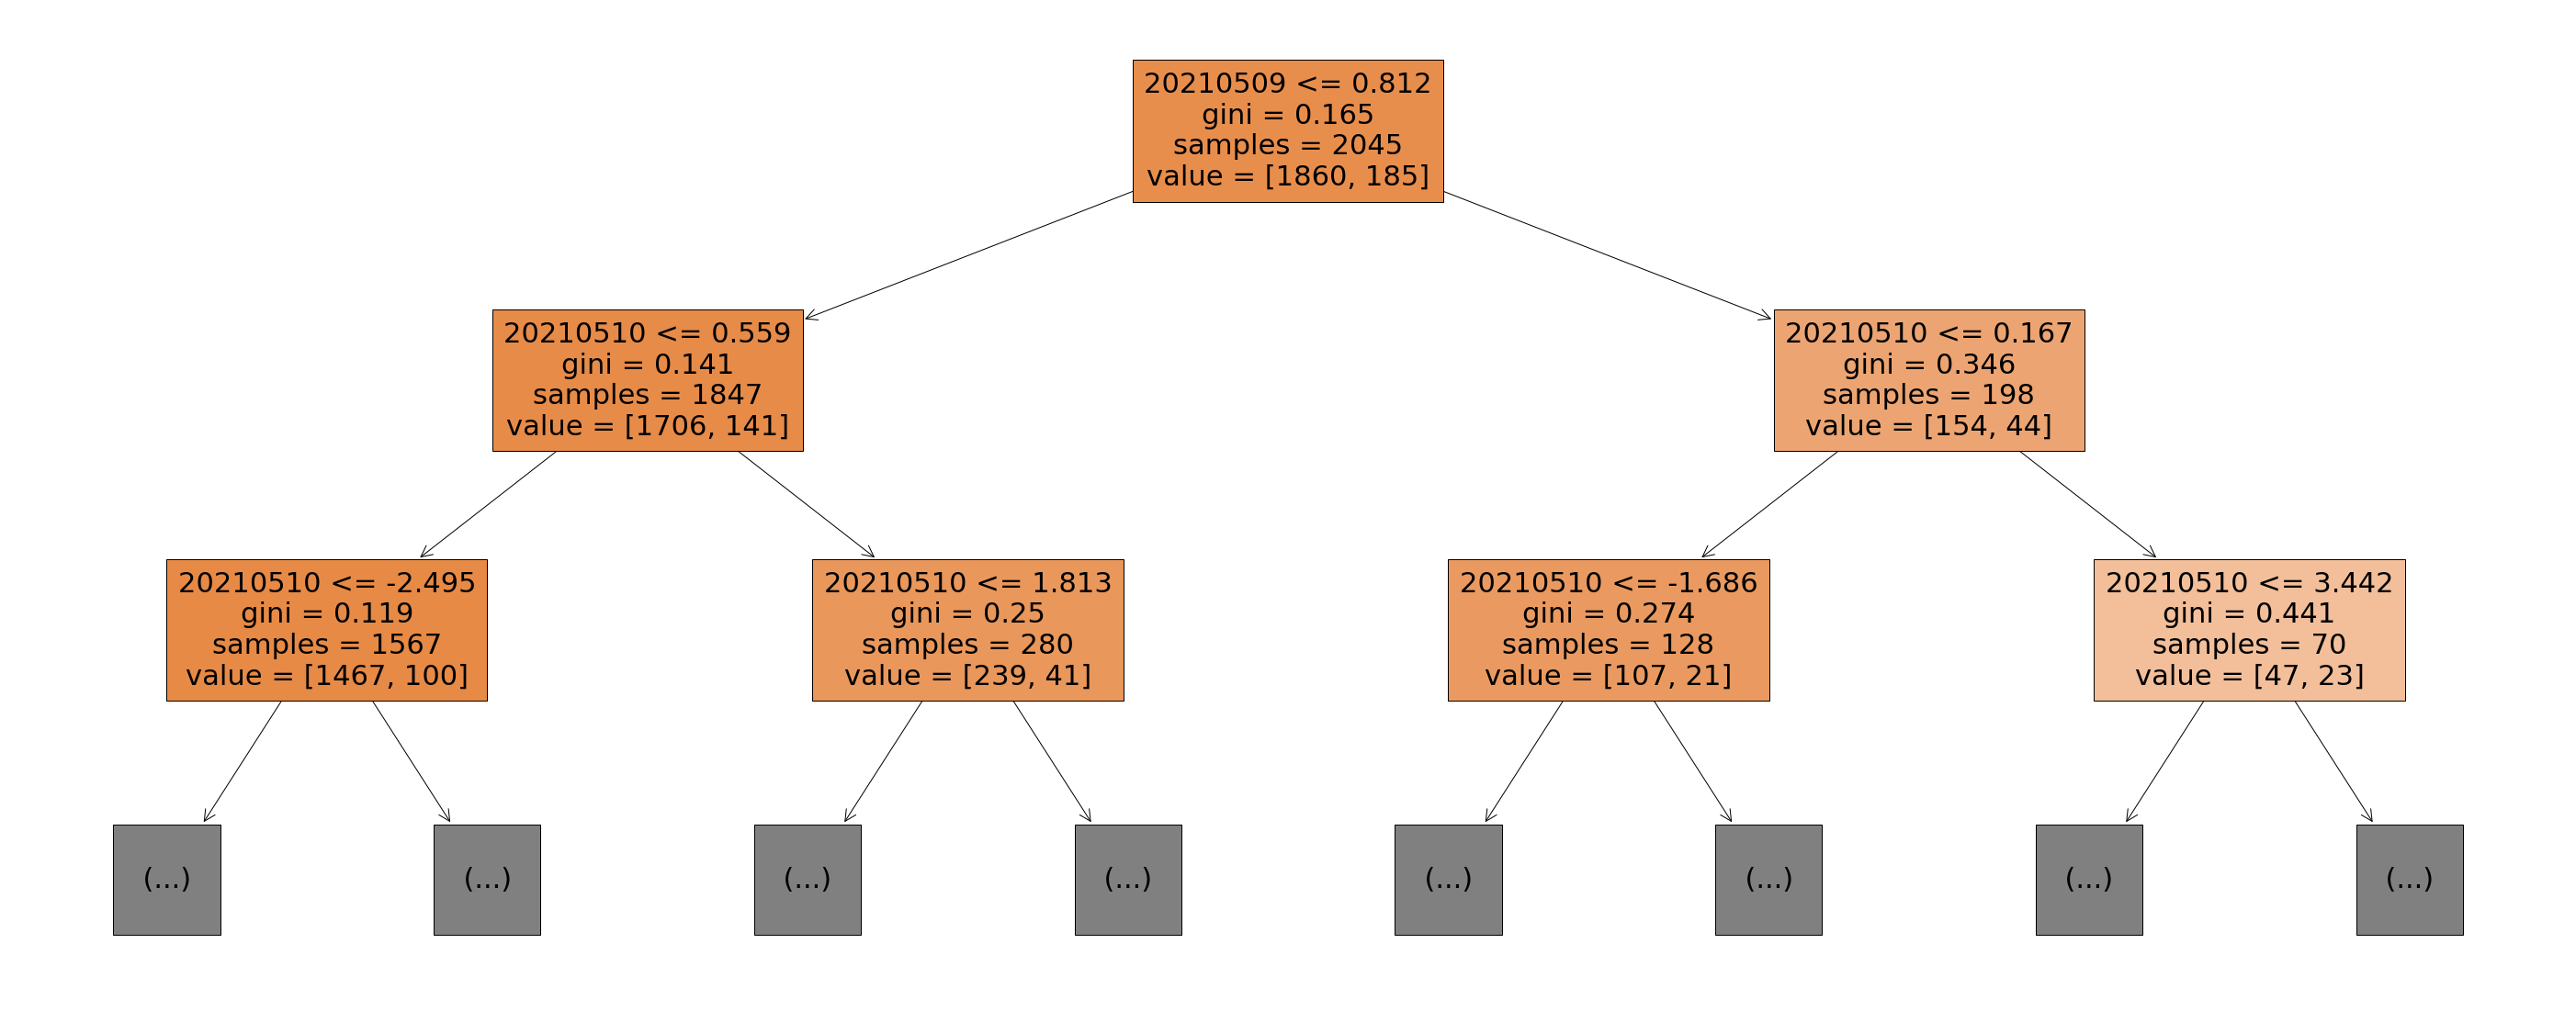

In [100]:
# 깊이 조절  but 리프노드를 볼 수 없음 
plt.figure(figsize=(50,20))
plot_tree(dt,max_depth=2,filled=True,feature_names=['20210510', '20210507'])
plt.show()

In [101]:
# 가지치기를 통해서 훈련세트의 성능은 낮아졌지만 테스트세트의 성능은 향상
# 가지를 일정 깊이까지만 자라게 함
dt= DecisionTreeClassifier(max_depth=4)
dt.fit(train_scaled,train_target)
print(dt.score(train_scaled,train_target))
print(dt.score(test_scaled,test_target))

0.9139364303178484
0.876953125


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


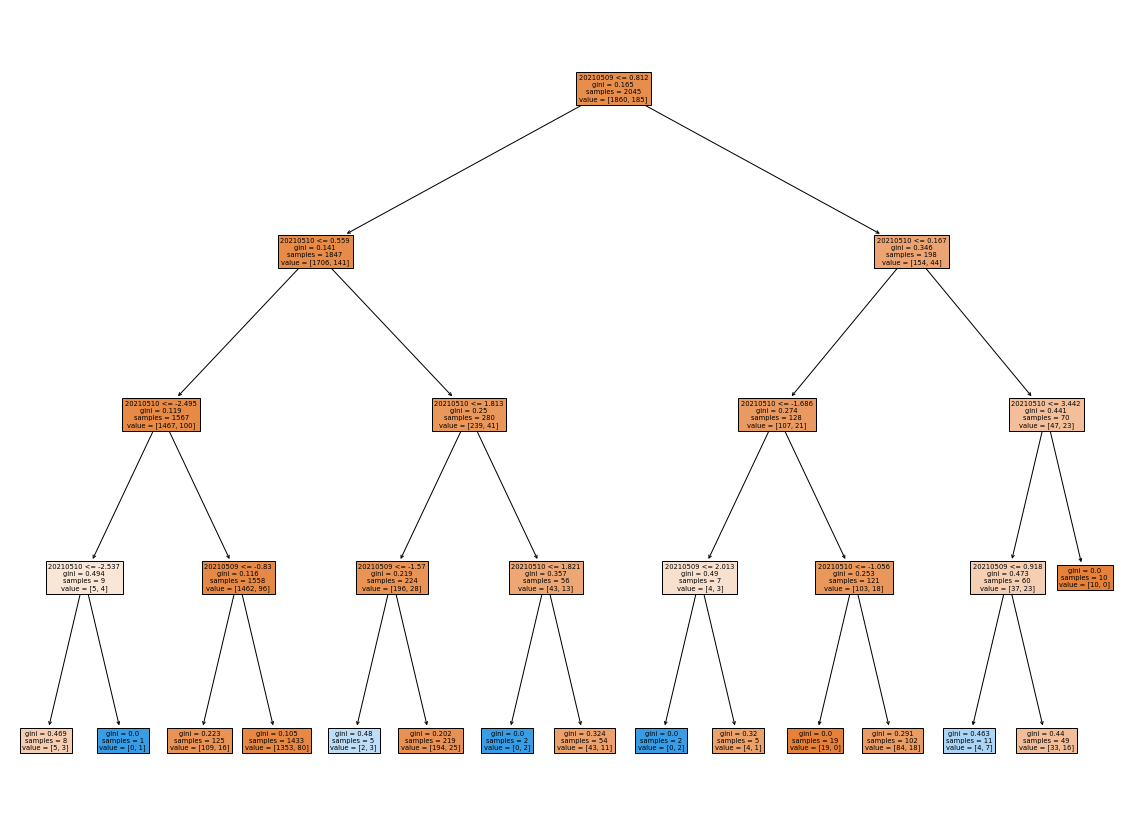

In [102]:
plt.figure(figsize=(20,15))
plot_tree(dt,filled=True,feature_names=['20210510', '20210507'])
plt.show()

In [109]:
# 표준화 전처리 전 샘플 (결정트리는 특성값의 스케일에 영향x)
dt= DecisionTreeClassifier(max_depth=5)
dt.fit(train_input,train_target)
print(dt.score(train_input,train_target))
print(dt.score(test_input,test_target))

0.9168704156479217
0.87890625


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


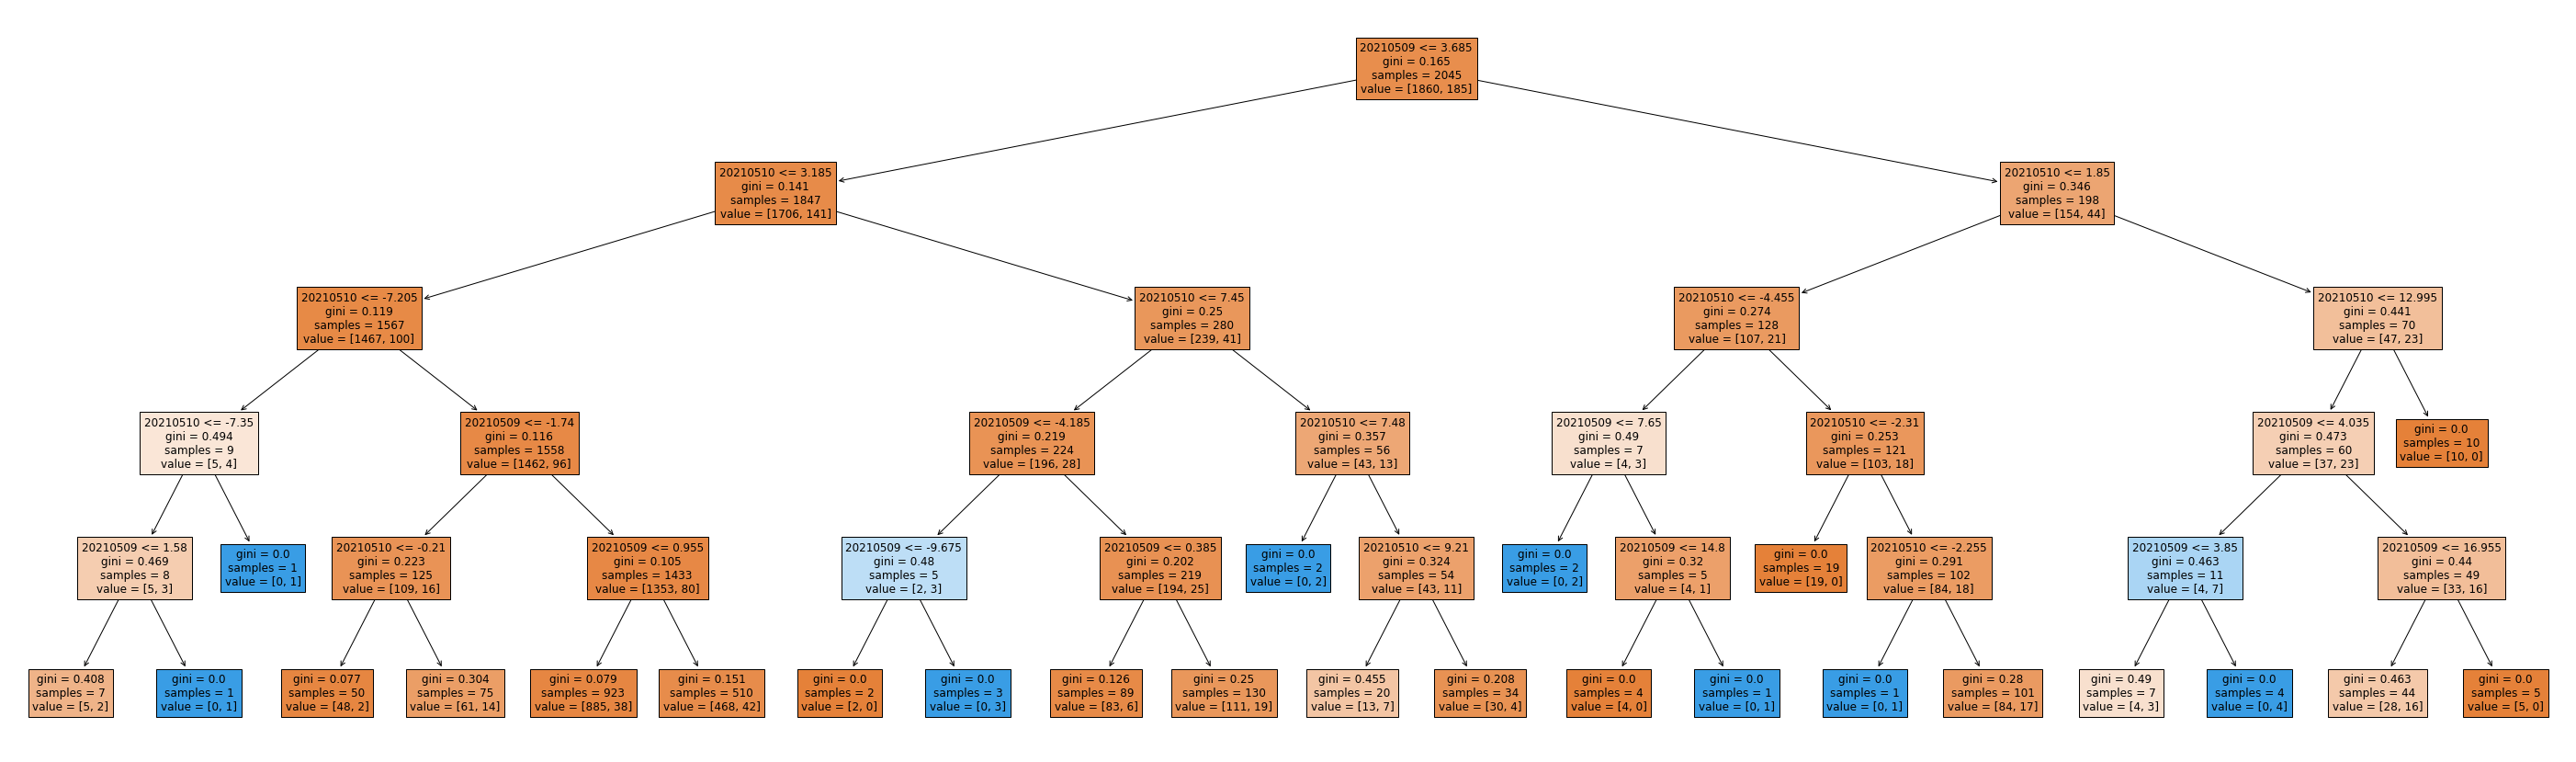

In [111]:
# 5월10일 1.85프로 초과 13프로 이하 7일 3.85프로 초과 4.035프로 이하일 경우 4개의 샘플이 100프로 3프로 이상올랐음  

plt.figure(figsize=(50,15))
plot_tree(dt,filled=True,feature_names=['20210510', '20210509'])
plt.show()

In [116]:
print(df_percent)

for i in df_percent.index:
  if df_percent["20210510"][i] <=12.995 and df_percent["20210510"][i] >1.85 and df_percent["20210507"][i] <= 4.035 and df_percent["20210507"][i] > 3.85: 
    print(df_percent.loc[[i]])
  


        20210511  20210510  20210507
060310         0     -0.50      3.98
095570         0      3.89      0.34
006840         0      5.47      1.86
054620         0      5.54     -0.34
265520         0      1.91      1.05
...          ...       ...       ...
000547         0      2.07     -2.64
000545         0      4.69     -3.40
003280         0      0.00      0.00
037440         0      3.77      4.40
238490         0      0.00      1.15

[2557 rows x 3 columns]
        20210511  20210510  20210507
012630         1     12.74      4.02
        20210511  20210510  20210507
008355         1      5.83       4.0
        20210511  20210510  20210507
004830         1      1.99       3.9
        20210511  20210510  20210507
004980         1      1.86      3.86
        20210511  20210510  20210507
046120         1      4.55       4.0


In [117]:

dt_index2 = pandas.date_range(start='20210826', end='20210827',freq='B')
dt_list2 = dt_index2.strftime("%Y%m%d").tolist()

df_percent2= stock.get_market_price_change_by_ticker(dt_list2[0],dt_list2[0],market="ALL")['등락률']
df_percent2=pandas.DataFrame(df_percent2)
df_percent2.columns=[dt_list2[0]]

for i in range(1,len(dt_index2)):
    try:
        df2 = stock.get_market_price_change_by_ticker(dt_list2[i], dt_list2[i],market="ALL")['등락률']
        df2 = pandas.DataFrame(df2)
        df2.columns = [dt_list2[i]]

        df_percent2 = pandas.concat([df2, df_percent2], axis=1)
    except:
        continue


df_percent2=df_percent2.dropna(axis=0)



print(df_percent2)

        20210827  20210826
060310      2.51      1.35
095570     -0.51     -1.69
006840      0.19      2.14
054620     -0.26     -0.51
265520     -0.89     -0.35
...          ...       ...
000547     -2.27      6.70
000545     -1.45      2.99
003280      0.00      0.00
037440      0.00     -0.48
238490      3.50      0.10

[2579 rows x 2 columns]


In [121]:
# 5월10일 1.85프로 초과 13프로 이하 7일 3.85프로 초과 4.035프로 이하일 경우 4개의 샘플이 100프로 3프로 이상올랐음  
# 26일 27일에 조건이 만족하는 샘플이 없어서 3.85프로 초과를 3프로 초과로 변경
for i in df_percent2.index:
  if df_percent2["20210827"][i] <=12.995 and df_percent2["20210827"][i] >1.85 and df_percent2["20210826"][i] <= 4.035 and df_percent2["20210826"][i] > 3: 
    print(df_percent2.loc[[i]])

        20210827  20210826
060310      2.51      1.35
095570     -0.51     -1.69
006840      0.19      2.14
054620     -0.26     -0.51
265520     -0.89     -0.35
...          ...       ...
000547     -2.27      6.70
000545     -1.45      2.99
003280      0.00      0.00
037440      0.00     -0.48
238490      3.50      0.10

[2579 rows x 2 columns]
        20210827  20210826
060720      3.35      3.25
        20210827  20210826
192080      3.81      3.25
        20210827  20210826
361390      2.68      3.33
        20210827  20210826
067000      1.91      3.47
        20210827  20210826
192820      4.72      3.25
